In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

class GridWorld:
    def __init__(self):
        # Grid dimensions (4x3)
        self.width = 4
        self.height = 3
        
        # Discount factor
        self.gamma = 0.9
        
        # Actions: 0=up, 1=down, 2=left, 3=right
        self.actions = ['up', 'down', 'left', 'right']
        self.action_map = {0: 'up', 1: 'down', 2: 'left', 3: 'right'}
        
        # Rewards
        self.rewards = {}
        for x in range(1, 5):
            for y in range(1, 4):
                if x == 4 and y == 3:
                    self.rewards[(x, y)] = 1.0  # Terminal state +1
                elif x == 4 and y == 2:
                    self.rewards[(x, y)] = -1.0  # Terminal state -1
                else:
                    self.rewards[(x, y)] = -0.04  # Living penalty
        
        # Terminal states
        self.terminal_states = {(4, 3), (4, 2)}
        
        # Walls (obstacles)
        self.walls = {(2, 2)}  # The gray cell in the grid
        
        # All valid states
        self.states = []
        for x in range(1, 5):
            for y in range(1, 4):
                if (x, y) not in self.walls:
                    self.states.append((x, y))
    
    def get_next_state(self, state, action):
        """Get next state given current state and action"""
        x, y = state
        
        # Action mappings
        if action == 0:  # up
            next_state = (x, y + 1)
        elif action == 1:  # down
            next_state = (x, y - 1)
        elif action == 2:  # left
            next_state = (x - 1, y)
        elif action == 3:  # right
            next_state = (x + 1, y)
        
        # Check boundaries and walls
        next_x, next_y = next_state
        if (next_x < 1 or next_x > 4 or next_y < 1 or next_y > 3 or 
            next_state in self.walls):
            return state  # Stay in same state if hit wall/boundary
        
        return next_state
    
    def get_transition_prob(self, state, action, next_state):
        """Get transition probability P(s'|s,a)"""
        if state in self.terminal_states:
            return 0.0
        
        # Get intended next state
        intended_next = self.get_next_state(state, action)
        
        # Get perpendicular actions
        if action in [0, 1]:  # up/down
            perp_actions = [2, 3]  # left/right
        else:  # left/right
            perp_actions = [0, 1]  # up/down
        
        # Calculate probabilities
        prob = 0.0
        
        # Intended action (probability 0.8)
        if next_state == intended_next:
            prob += 0.8
        
        # Perpendicular actions (probability 0.1 each)
        for perp_action in perp_actions:
            perp_next = self.get_next_state(state, perp_action)
            if next_state == perp_next:
                prob += 0.1
        
        return prob
    
    def get_reward(self, state):
        """Get reward for being in a state"""
        return self.rewards.get(state, 0.0)

class PolicyIteration:
    def __init__(self, grid_world):
        self.grid_world = grid_world
        self.states = grid_world.states
        self.actions = list(range(4))  # 0,1,2,3 for up,down,left,right
        
        # Initialize random policy
        self.policy = {}
        for state in self.states:
            if state not in grid_world.terminal_states:
                self.policy[state] = np.random.choice(self.actions)
        
        # Initialize utilities
        self.utilities = {state: 0.0 for state in self.states}
    
    def policy_evaluation(self, max_iterations=1000, tolerance=1e-6):
        """Evaluate current policy"""
        for _ in range(max_iterations):
            new_utilities = {}
            max_change = 0
            
            for state in self.states:
                if state in self.grid_world.terminal_states:
                    new_utilities[state] = self.grid_world.get_reward(state)
                else:
                    action = self.policy[state]
                    utility = 0.0
                    
                    # Sum over all possible next states
                    for next_state in self.states:
                        prob = self.grid_world.get_transition_prob(state, action, next_state)
                        if prob > 0:
                            reward = self.grid_world.get_reward(next_state)
                            utility += prob * (reward + self.grid_world.gamma * self.utilities[next_state])
                    
                    new_utilities[state] = utility
                    max_change = max(max_change, abs(new_utilities[state] - self.utilities[state]))
            
            self.utilities = new_utilities
            
            if max_change < tolerance:
                break
    
    def policy_improvement(self):
        """Improve policy based on current utilities"""
        policy_changed = False
        
        for state in self.states:
            if state in self.grid_world.terminal_states:
                continue
            
            best_action = None
            best_utility = float('-inf')
            
            # Try all actions
            for action in self.actions:
                utility = 0.0
                
                # Sum over all possible next states
                for next_state in self.states:
                    prob = self.grid_world.get_transition_prob(state, action, next_state)
                    if prob > 0:
                        reward = self.grid_world.get_reward(next_state)
                        utility += prob * (reward + self.grid_world.gamma * self.utilities[next_state])
                
                if utility > best_utility:
                    best_utility = utility
                    best_action = action
            
            if best_action != self.policy.get(state):
                self.policy[state] = best_action
                policy_changed = True
        
        return policy_changed
    
    def run(self, max_iterations=100):
        """Run policy iteration algorithm"""
        for iteration in range(max_iterations):
            # Policy evaluation
            self.policy_evaluation()
            
            # Policy improvement
            if not self.policy_improvement():
                print(f"Policy iteration converged after {iteration + 1} iterations")
                break
        
        return self.utilities, self.policy

class ValueIteration:
    def __init__(self, grid_world):
        self.grid_world = grid_world
        self.states = grid_world.states
        self.actions = list(range(4))  # 0,1,2,3 for up,down,left,right
        
        # Initialize utilities
        self.utilities = {state: 0.0 for state in self.states}
    
    def run(self, max_iterations=1000, tolerance=1e-6):
        """Run value iteration algorithm"""
        for iteration in range(max_iterations):
            new_utilities = {}
            max_change = 0
            
            for state in self.states:
                if state in self.grid_world.terminal_states:
                    new_utilities[state] = self.grid_world.get_reward(state)
                else:
                    best_utility = float('-inf')
                    
                    # Try all actions
                    for action in self.actions:
                        utility = 0.0
                        
                        # Sum over all possible next states
                        for next_state in self.states:
                            prob = self.grid_world.get_transition_prob(state, action, next_state)
                            if prob > 0:
                                reward = self.grid_world.get_reward(next_state)
                                utility += prob * (reward + self.grid_world.gamma * self.utilities[next_state])
                        
                        best_utility = max(best_utility, utility)
                    
                    new_utilities[state] = best_utility
                    max_change = max(max_change, abs(new_utilities[state] - self.utilities[state]))
            
            self.utilities = new_utilities
            
            if max_change < tolerance:
                print(f"Value iteration converged after {iteration + 1} iterations")
                break
        
        # Extract optimal policy
        policy = {}
        for state in self.states:
            if state in self.grid_world.terminal_states:
                continue
            
            best_action = None
            best_utility = float('-inf')
            
            for action in self.actions:
                utility = 0.0
                
                for next_state in self.states:
                    prob = self.grid_world.get_transition_prob(state, action, next_state)
                    if prob > 0:
                        reward = self.grid_world.get_reward(next_state)
                        utility += prob * (reward + self.grid_world.gamma * self.utilities[next_state])
                
                if utility > best_utility:
                    best_utility = utility
                    best_action = action
            
            policy[state] = best_action
        
        return self.utilities, policy

def format_results(utilities, policy, grid_world):
    """Format results for display"""
    print("\nUtility Values U(s) = (x,y):")
    print("=" * 50)
    
    # Create utility table
    utility_table = []
    for y in range(3, 0, -1):  # From top to bottom
        row = []
        for x in range(1, 5):  # From left to right
            if (x, y) in grid_world.walls:
                row.append("WALL")
            else:
                row.append(f"{utilities.get((x, y), 0.0):.3f}")
        utility_table.append(row)
    
    # Print utility table
    print("\nTable 1: Utility values")
    print("Y\\X   1       2       3       4")
    for i, row in enumerate(utility_table):
        print(f"{3-i}   {row[0]:>7} {row[1]:>7} {row[2]:>7} {row[3]:>7}")
    
    print("\nOptimal Policy π*:")
    print("=" * 50)
    
    # Create policy table
    policy_table = []
    for y in range(3, 0, -1):  # From top to bottom
        row = []
        for x in range(1, 5):  # From left to right
            if (x, y) in grid_world.walls:
                row.append("WALL")
            elif (x, y) in grid_world.terminal_states:
                row.append("TERMINAL")
            else:
                action = policy.get((x, y), 0)
                row.append(grid_world.action_map[action])
        policy_table.append(row)
    
    # Print policy table
    print("\nTable 2: Optimal policy")
    print("Y\\X   1       2       3       4")
    for i, row in enumerate(policy_table):
        print(f"{3-i}   {row[0]:>7} {row[1]:>7} {row[2]:>7} {row[3]:>7}")

def main():
    # Create grid world
    grid_world = GridWorld()
    
    print("Reinforcement Learning Assignment")
    print("=" * 50)
    print("Grid World Environment:")
    print("- 4x3 grid")
    print("- Start state: (1,1)")
    print("- Terminal states: (4,3) with reward +1, (4,2) with reward -1")
    print("- Wall at: (2,2)")
    print("- Living penalty: -0.04")
    print("- Discount factor γ = 0.9")
    print("- Action probabilities: intended 0.8, perpendicular 0.1 each")
    
    print("\n" + "=" * 50)
    print("POLICY ITERATION")
    print("=" * 50)
    
    # Run Policy Iteration
    pi = PolicyIteration(grid_world)
    pi_utilities, pi_policy = pi.run()
    
    print("\nPolicy Iteration Results:")
    format_results(pi_utilities, pi_policy, grid_world)
    
    print("\n" + "=" * 50)
    print("VALUE ITERATION")
    print("=" * 50)
    
    # Run Value Iteration
    vi = ValueIteration(grid_world)
    vi_utilities, vi_policy = vi.run()
    
    print("\nValue Iteration Results:")
    format_results(vi_utilities, vi_policy, grid_world)
    
    print("\n" + "=" * 50)
    print("COMPARISON")
    print("=" * 50)
    
    # Compare results
    print("\nUtility differences between methods:")
    max_diff = 0
    for state in grid_world.states:
        diff = abs(pi_utilities[state] - vi_utilities[state])
        max_diff = max(max_diff, diff)
        if diff > 1e-3:
            print(f"State {state}: PI={pi_utilities[state]:.6f}, VI={vi_utilities[state]:.6f}, Diff={diff:.6f}")
    
    print(f"\nMaximum utility difference: {max_diff:.6f}")
    
    # Check policy agreement
    policy_agreement = 0
    total_non_terminal = 0
    for state in grid_world.states:
        if state not in grid_world.terminal_states:
            total_non_terminal += 1
            if pi_policy.get(state) == vi_policy.get(state):
                policy_agreement += 1
    
    print(f"Policy agreement: {policy_agreement}/{total_non_terminal} states ({100*policy_agreement/total_non_terminal:.1f}%)")

if __name__ == "__main__":
    main()

Reinforcement Learning Assignment
Grid World Environment:
- 4x3 grid
- Start state: (1,1)
- Terminal states: (4,3) with reward +1, (4,2) with reward -1
- Wall at: (2,2)
- Living penalty: -0.04
- Discount factor γ = 0.9
- Action probabilities: intended 0.8, perpendicular 0.1 each

POLICY ITERATION
Policy iteration converged after 5 iterations

Policy Iteration Results:

Utility Values U(s) = (x,y):

Table 1: Utility values
Y\X   1       2       3       4
3     1.255   1.511   1.776   1.000
2     1.054    WALL   1.157  -1.000
1     0.863   0.743   0.902   0.465

Optimal Policy π*:

Table 2: Optimal policy
Y\X   1       2       3       4
3     right   right   right TERMINAL
2        up    WALL      up TERMINAL
1        up   right      up    left

VALUE ITERATION
Value iteration converged after 22 iterations

Value Iteration Results:

Utility Values U(s) = (x,y):

Table 1: Utility values
Y\X   1       2       3       4
3     1.255   1.511   1.776   1.000
2     1.054    WALL   1.157  -1.000

Reinforcement Learning Assignment
Grid World Environment:
- 4x3 grid
- Start state: (1,1)
- Terminal states: (4,3) with reward +1, (4,2) with reward -1
- Wall at: (2,2)
- Living penalty: -0.04
- Discount factor γ = 0.9
- Action probabilities: intended 0.8, perpendicular 0.1 each

GRID WORLD VISUALIZATION


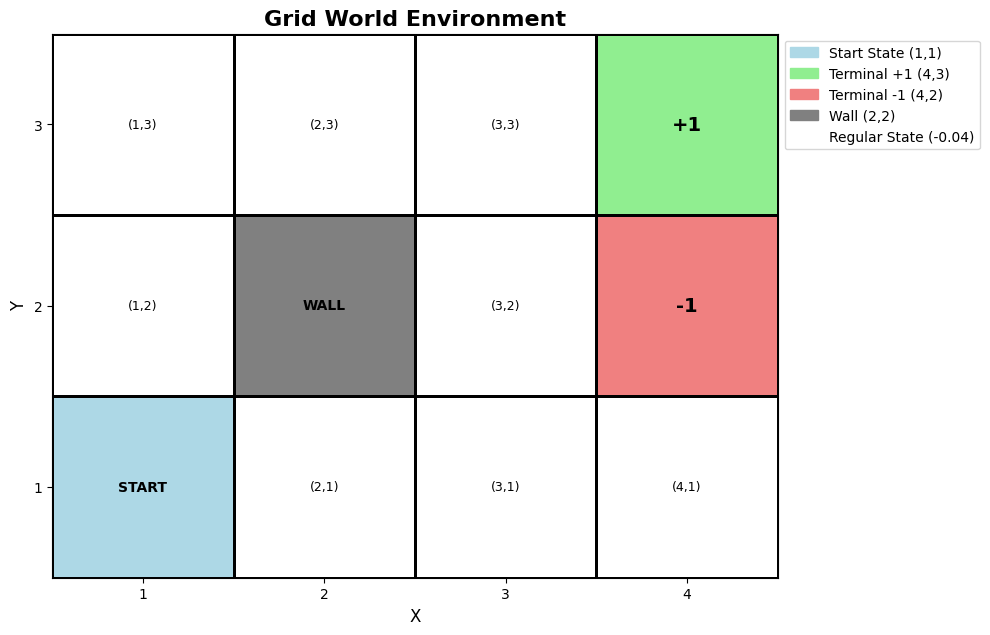


POLICY ITERATION
Policy iteration converged after 3 iterations

Policy Iteration Results:

Utility Values U(s) = (x,y):

Table 1: Utility values
Y\X   1       2       3       4
3     1.255   1.511   1.776   1.000
2     1.054    WALL   1.157  -1.000
1     0.863   0.743   0.902   0.465

Optimal Policy π*:

Table 2: Optimal policy
Y\X   1       2       3       4
3     right   right   right TERMINAL
2        up    WALL      up TERMINAL
1        up   right      up    left

Generating Policy Iteration Visualizations...


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


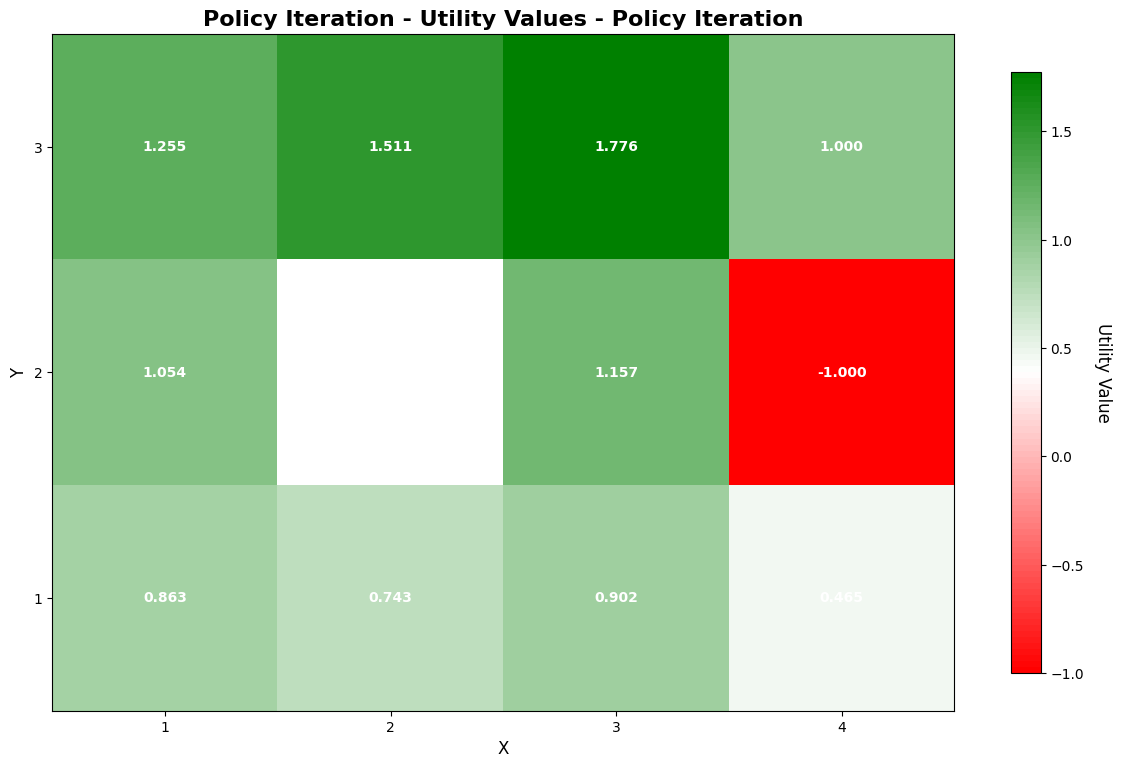

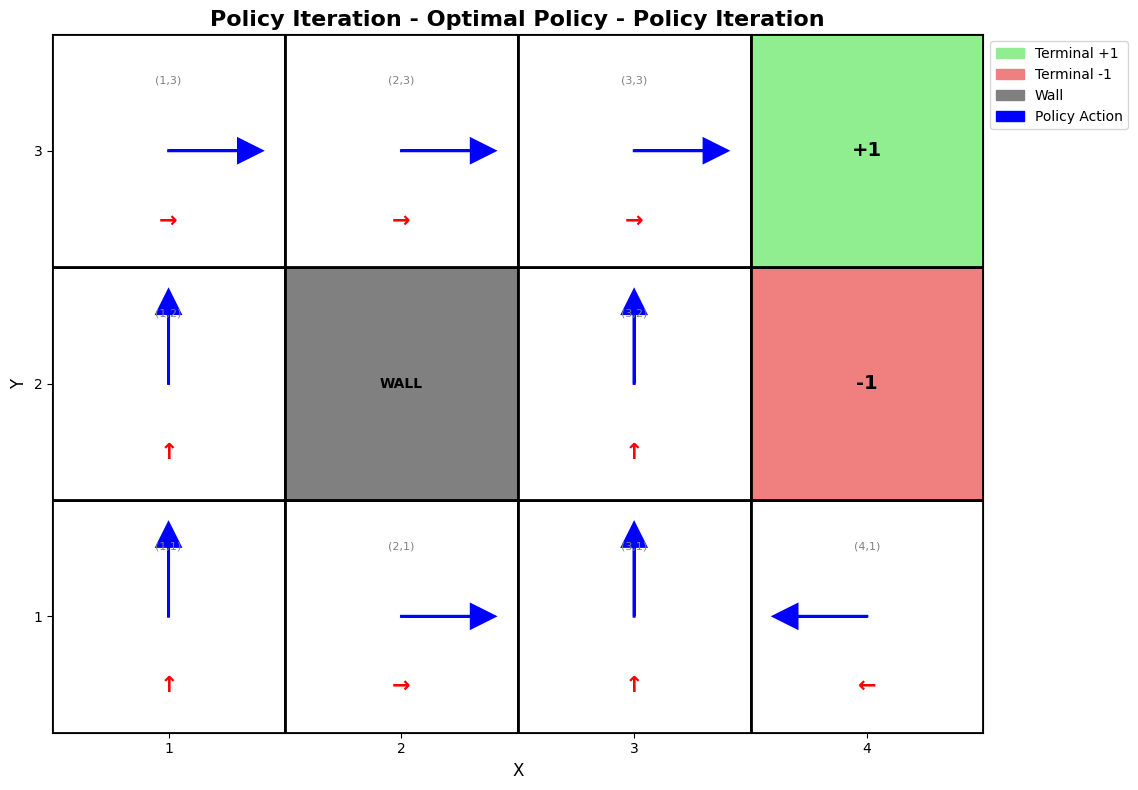

Analyzing Policy Iteration Convergence...


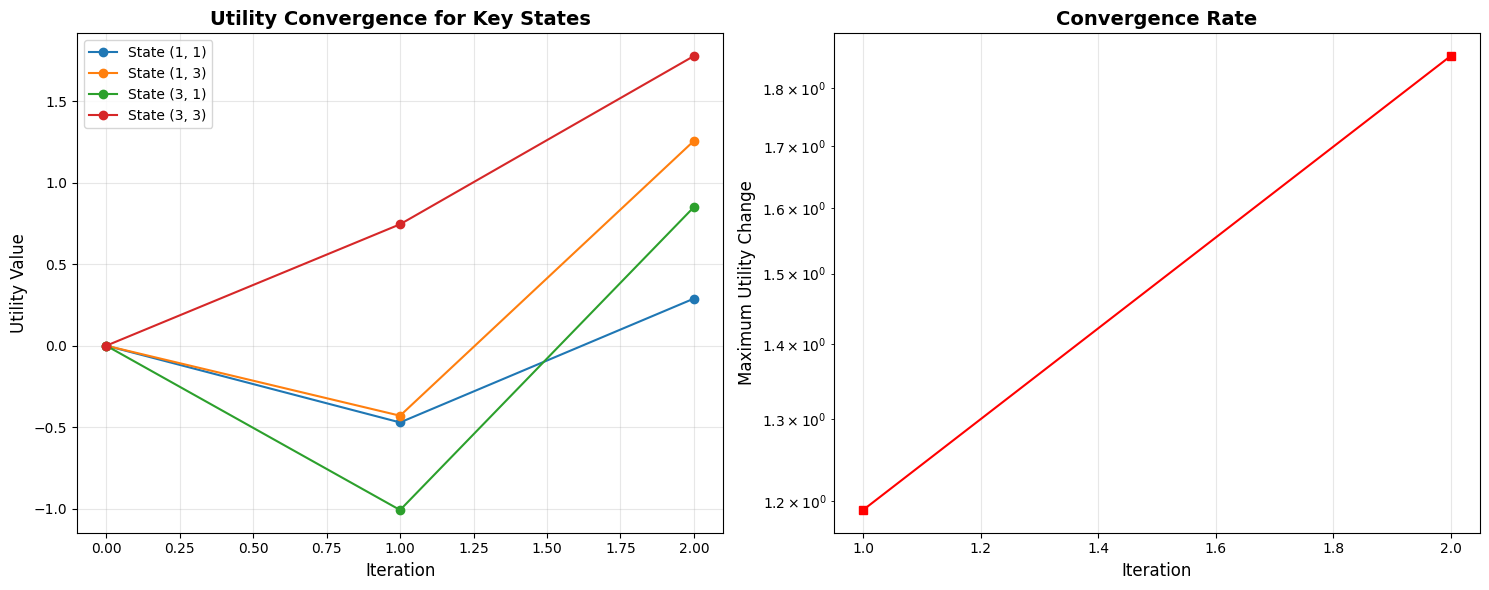


VALUE ITERATION
Value iteration converged after 22 iterations

Value Iteration Results:

Utility Values U(s) = (x,y):

Table 1: Utility values
Y\X   1       2       3       4
3     1.255   1.511   1.776   1.000
2     1.054    WALL   1.157  -1.000
1     0.863   0.743   0.902   0.465

Optimal Policy π*:

Table 2: Optimal policy
Y\X   1       2       3       4
3     right   right   right TERMINAL
2        up    WALL      up TERMINAL
1        up   right      up    left

Generating Value Iteration Visualizations...


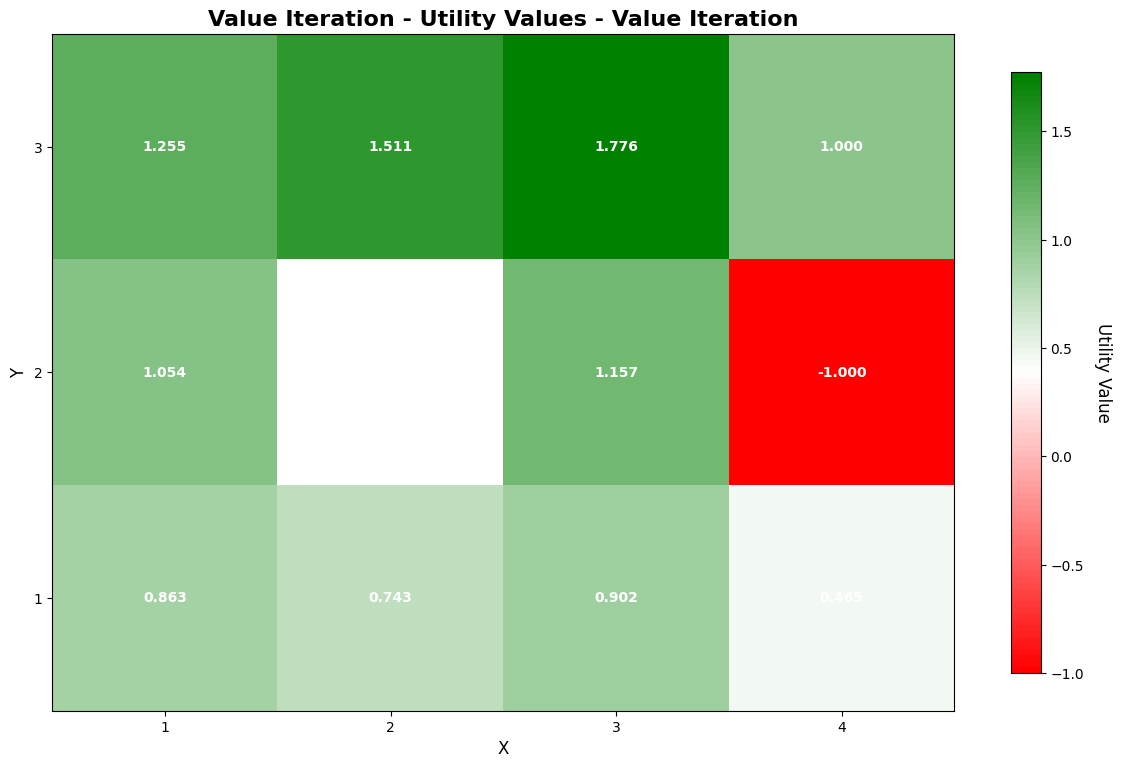

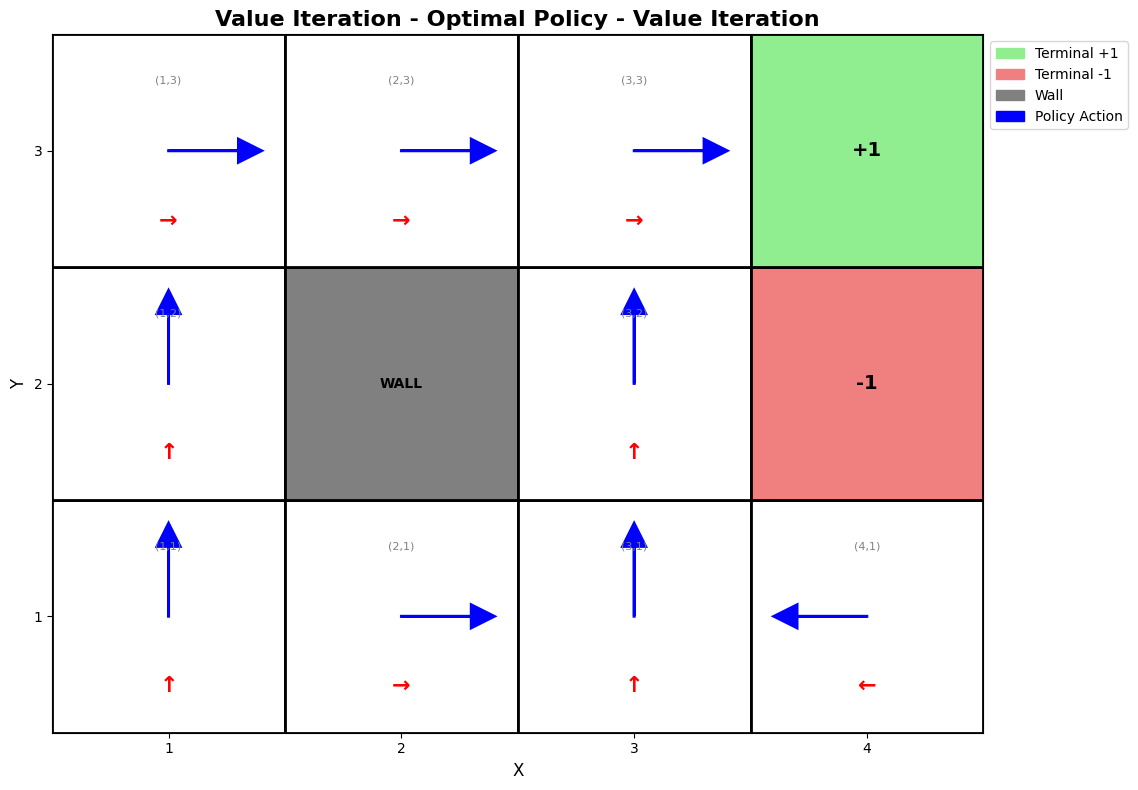

Analyzing Value Iteration Convergence...


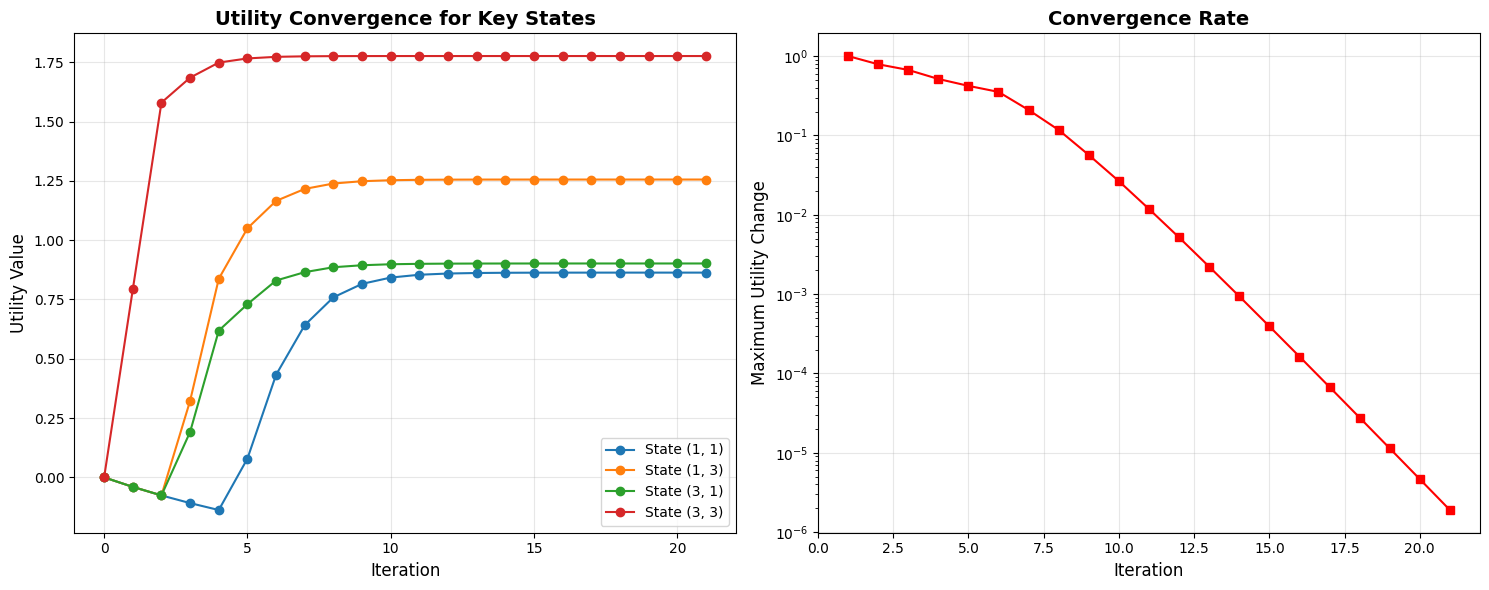


ALGORITHM COMPARISON
Comparing Policy Iteration vs Value Iteration...


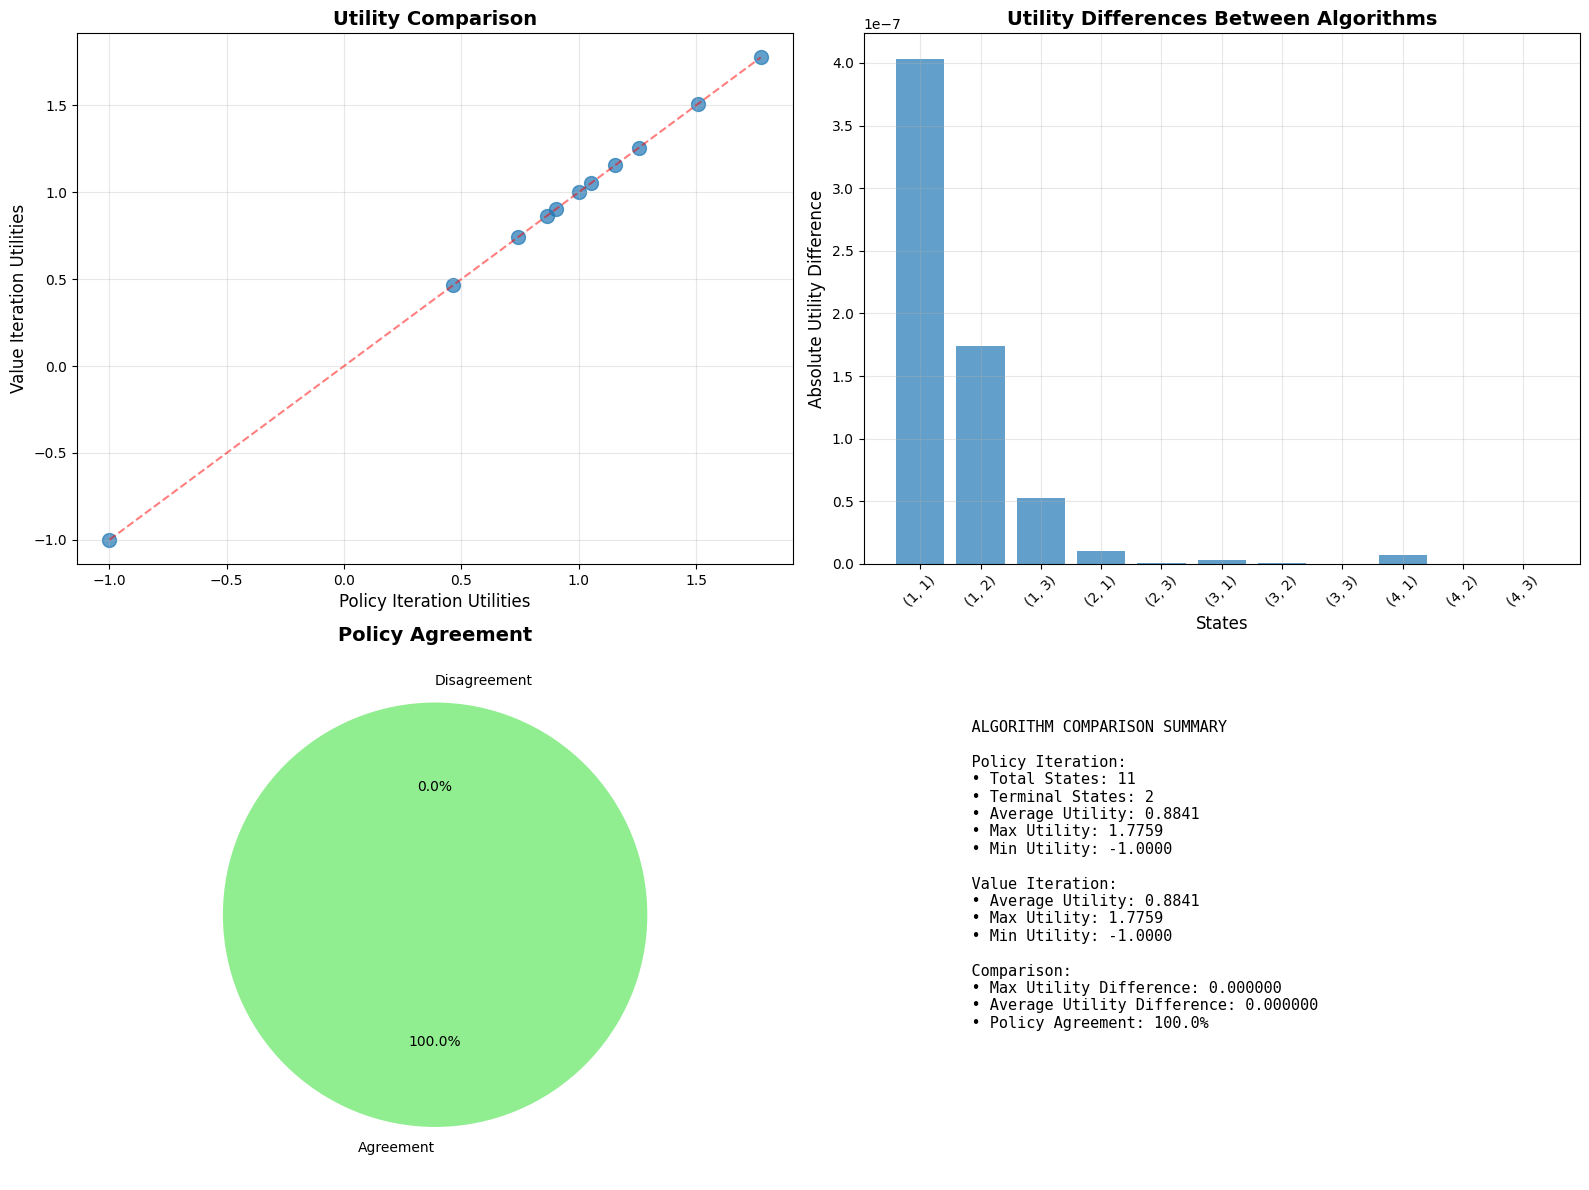


Detailed Comparison:
------------------------------
Maximum utility difference: 0.00000040
Average utility difference: 0.00000006
Policy agreement rate: 100.0%

State-by-State Comparison:
State		PI Utility	VI Utility	Difference	PI Action	VI Action	Agree
------------------------------------------------------------------------------------------
(1, 1)		0.863092	0.863091	0.000000	  up		  up		✓
(1, 2)		1.053549	1.053549	0.000000	  up		  up		✓
(1, 3)		1.255431	1.255431	0.000000	right		right		✓
(2, 1)		0.742867	0.742867	0.000000	right		right		✓
(2, 3)		1.510587	1.510587	0.000000	right		right		✓
(3, 1)		0.901599	0.901599	0.000000	  up		  up		✓
(3, 2)		1.156793	1.156793	0.000000	  up		  up		✓
(3, 3)		1.775947	1.775947	0.000000	right		right		✓
(4, 1)		0.465001	0.465001	0.000000	left		left		✓

PERFORMANCE ANALYSIS
Policy Iteration convergence: 3 iterations
Value Iteration convergence: 22 iterations

Expected utility from start state (1, 1):
Policy Iteration: 0.863092
Value Iteration: 0.863091
D

In [7]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, FancyBboxPatch
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

class GridWorld:
    def __init__(self):
        # Grid dimensions (4x3)
        self.width = 4
        self.height = 3
        
        # Discount factor
        self.gamma = 0.9
        
        # Actions: 0=up, 1=down, 2=left, 3=right
        self.actions = ['up', 'down', 'left', 'right']
        self.action_map = {0: 'up', 1: 'down', 2: 'left', 3: 'right'}
        
        # Rewards
        self.rewards = {}
        for x in range(1, 5):
            for y in range(1, 4):
                if x == 4 and y == 3:
                    self.rewards[(x, y)] = 1.0  # Terminal state +1
                elif x == 4 and y == 2:
                    self.rewards[(x, y)] = -1.0  # Terminal state -1
                else:
                    self.rewards[(x, y)] = -0.04  # Living penalty
        
        # Terminal states
        self.terminal_states = {(4, 3), (4, 2)}
        
        # Walls (obstacles)
        self.walls = {(2, 2)}  # The gray cell in the grid
        
        # All valid states
        self.states = []
        for x in range(1, 5):
            for y in range(1, 4):
                if (x, y) not in self.walls:
                    self.states.append((x, y))
    
    def get_next_state(self, state, action):
        """Get next state given current state and action"""
        x, y = state
        
        # Action mappings
        if action == 0:  # up
            next_state = (x, y + 1)
        elif action == 1:  # down
            next_state = (x, y - 1)
        elif action == 2:  # left
            next_state = (x - 1, y)
        elif action == 3:  # right
            next_state = (x + 1, y)
        
        # Check boundaries and walls
        next_x, next_y = next_state
        if (next_x < 1 or next_x > 4 or next_y < 1 or next_y > 3 or 
            next_state in self.walls):
            return state  # Stay in same state if hit wall/boundary
        
        return next_state
    
    def get_transition_prob(self, state, action, next_state):
        """Get transition probability P(s'|s,a)"""
        if state in self.terminal_states:
            return 0.0
        
        # Get intended next state
        intended_next = self.get_next_state(state, action)
        
        # Get perpendicular actions
        if action in [0, 1]:  # up/down
            perp_actions = [2, 3]  # left/right
        else:  # left/right
            perp_actions = [0, 1]  # up/down
        
        # Calculate probabilities
        prob = 0.0
        
        # Intended action (probability 0.8)
        if next_state == intended_next:
            prob += 0.8
        
        # Perpendicular actions (probability 0.1 each)
        for perp_action in perp_actions:
            perp_next = self.get_next_state(state, perp_action)
            if next_state == perp_next:
                prob += 0.1
        
        return prob
    
    def get_reward(self, state):
        """Get reward for being in a state"""
        return self.rewards.get(state, 0.0)

class PolicyIteration:
    def __init__(self, grid_world):
        self.grid_world = grid_world
        self.states = grid_world.states
        self.actions = list(range(4))  # 0,1,2,3 for up,down,left,right
        
        # Initialize random policy
        self.policy = {}
        for state in self.states:
            if state not in grid_world.terminal_states:
                self.policy[state] = np.random.choice(self.actions)
        
        # Initialize utilities
        self.utilities = {state: 0.0 for state in self.states}
        
        # For tracking convergence
        self.utilities_history = []
    
    def policy_evaluation(self, max_iterations=1000, tolerance=1e-6):
        """Evaluate current policy"""
        for _ in range(max_iterations):
            new_utilities = {}
            max_change = 0
            
            for state in self.states:
                if state in self.grid_world.terminal_states:
                    new_utilities[state] = self.grid_world.get_reward(state)
                else:
                    action = self.policy[state]
                    utility = 0.0
                    
                    # Sum over all possible next states
                    for next_state in self.states:
                        prob = self.grid_world.get_transition_prob(state, action, next_state)
                        if prob > 0:
                            reward = self.grid_world.get_reward(next_state)
                            utility += prob * (reward + self.grid_world.gamma * self.utilities[next_state])
                    
                    new_utilities[state] = utility
                    max_change = max(max_change, abs(new_utilities[state] - self.utilities[state]))
            
            self.utilities = new_utilities
            
            if max_change < tolerance:
                break
    
    def policy_improvement(self):
        """Improve policy based on current utilities"""
        policy_changed = False
        
        for state in self.states:
            if state in self.grid_world.terminal_states:
                continue
            
            best_action = None
            best_utility = float('-inf')
            
            # Try all actions
            for action in self.actions:
                utility = 0.0
                
                # Sum over all possible next states
                for next_state in self.states:
                    prob = self.grid_world.get_transition_prob(state, action, next_state)
                    if prob > 0:
                        reward = self.grid_world.get_reward(next_state)
                        utility += prob * (reward + self.grid_world.gamma * self.utilities[next_state])
                
                if utility > best_utility:
                    best_utility = utility
                    best_action = action
            
            if best_action != self.policy.get(state):
                self.policy[state] = best_action
                policy_changed = True
        
        return policy_changed
    
    def run(self, max_iterations=100):
        """Run policy iteration algorithm"""
        for iteration in range(max_iterations):
            # Store utilities for convergence tracking
            self.utilities_history.append(self.utilities.copy())
            
            # Policy evaluation
            self.policy_evaluation()
            
            # Policy improvement
            if not self.policy_improvement():
                print(f"Policy iteration converged after {iteration + 1} iterations")
                break
        
        return self.utilities, self.policy

class ValueIteration:
    def __init__(self, grid_world):
        self.grid_world = grid_world
        self.states = grid_world.states
        self.actions = list(range(4))  # 0,1,2,3 for up,down,left,right
        
        # Initialize utilities
        self.utilities = {state: 0.0 for state in self.states}
        
        # For tracking convergence
        self.utilities_history = []
    
    def run(self, max_iterations=1000, tolerance=1e-6):
        """Run value iteration algorithm"""
        for iteration in range(max_iterations):
            # Store utilities for convergence tracking
            self.utilities_history.append(self.utilities.copy())
            
            new_utilities = {}
            max_change = 0
            
            for state in self.states:
                if state in self.grid_world.terminal_states:
                    new_utilities[state] = self.grid_world.get_reward(state)
                else:
                    best_utility = float('-inf')
                    
                    # Try all actions
                    for action in self.actions:
                        utility = 0.0
                        
                        # Sum over all possible next states
                        for next_state in self.states:
                            prob = self.grid_world.get_transition_prob(state, action, next_state)
                            if prob > 0:
                                reward = self.grid_world.get_reward(next_state)
                                utility += prob * (reward + self.grid_world.gamma * self.utilities[next_state])
                        
                        best_utility = max(best_utility, utility)
                    
                    new_utilities[state] = best_utility
                    max_change = max(max_change, abs(new_utilities[state] - self.utilities[state]))
            
            self.utilities = new_utilities
            
            if max_change < tolerance:
                print(f"Value iteration converged after {iteration + 1} iterations")
                break
        
        # Extract optimal policy
        policy = {}
        for state in self.states:
            if state in self.grid_world.terminal_states:
                continue
            
            best_action = None
            best_utility = float('-inf')
            
            for action in self.actions:
                utility = 0.0
                
                for next_state in self.states:
                    prob = self.grid_world.get_transition_prob(state, action, next_state)
                    if prob > 0:
                        reward = self.grid_world.get_reward(next_state)
                        utility += prob * (reward + self.grid_world.gamma * self.utilities[next_state])
                
                if utility > best_utility:
                    best_utility = utility
                    best_action = action
            
            policy[state] = best_action
        
        return self.utilities, policy

def visualize_grid_world(grid_world, title="Grid World Environment"):
    """Visualize the grid world environment"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Set up the plot
    ax.set_xlim(0.5, 4.5)
    ax.set_ylim(0.5, 3.5)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    # Draw grid
    for x in range(1, 5):
        ax.axvline(x - 0.5, color='black', linewidth=2)
        ax.axvline(x + 0.5, color='black', linewidth=2)
    for y in range(1, 4):
        ax.axhline(y - 0.5, color='black', linewidth=2)
        ax.axhline(y + 0.5, color='black', linewidth=2)
    
    # Draw cells
    for x in range(1, 5):
        for y in range(1, 4):
            if (x, y) in grid_world.walls:
                # Wall cell
                rect = Rectangle((x-0.5, y-0.5), 1, 1, facecolor='gray', edgecolor='black', linewidth=2)
                ax.add_patch(rect)
                ax.text(x, y, 'WALL', ha='center', va='center', fontsize=10, fontweight='bold')
            elif (x, y) == (4, 3):
                # Positive terminal state
                rect = Rectangle((x-0.5, y-0.5), 1, 1, facecolor='lightgreen', edgecolor='black', linewidth=2)
                ax.add_patch(rect)
                ax.text(x, y, '+1', ha='center', va='center', fontsize=14, fontweight='bold')
            elif (x, y) == (4, 2):
                # Negative terminal state
                rect = Rectangle((x-0.5, y-0.5), 1, 1, facecolor='lightcoral', edgecolor='black', linewidth=2)
                ax.add_patch(rect)
                ax.text(x, y, '-1', ha='center', va='center', fontsize=14, fontweight='bold')
            elif (x, y) == (1, 1):
                # Start state
                rect = Rectangle((x-0.5, y-0.5), 1, 1, facecolor='lightblue', edgecolor='black', linewidth=2)
                ax.add_patch(rect)
                ax.text(x, y, 'START', ha='center', va='center', fontsize=10, fontweight='bold')
            else:
                # Regular state
                rect = Rectangle((x-0.5, y-0.5), 1, 1, facecolor='white', edgecolor='black', linewidth=2)
                ax.add_patch(rect)
                ax.text(x, y, f'({x},{y})', ha='center', va='center', fontsize=9)
    
    # Add coordinate labels
    ax.set_xticks(range(1, 5))
    ax.set_yticks(range(1, 4))
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    
    # Add legend
    legend_elements = [
        mpatches.Patch(color='lightblue', label='Start State (1,1)'),
        mpatches.Patch(color='lightgreen', label='Terminal +1 (4,3)'),
        mpatches.Patch(color='lightcoral', label='Terminal -1 (4,2)'),
        mpatches.Patch(color='gray', label='Wall (2,2)'),
        mpatches.Patch(color='white', label='Regular State (-0.04)')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

def visualize_utilities(utilities, grid_world, title="Utility Values", algorithm=""):
    """Visualize utility values as a heatmap"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Create utility matrix
    utility_matrix = np.zeros((3, 4))
    for x in range(1, 5):
        for y in range(1, 4):
            if (x, y) not in grid_world.walls:
                utility_matrix[3-y, x-1] = utilities.get((x, y), 0)
            else:
                utility_matrix[3-y, x-1] = np.nan
    
    # Create custom colormap
    colors = ['red', 'white', 'green']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    
    # Create heatmap
    im = ax.imshow(utility_matrix, cmap=cmap, aspect='equal')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Utility Value', rotation=270, labelpad=20, fontsize=12)
    
    # Add text annotations
    for i in range(3):
        for j in range(4):
            x, y = j + 1, 3 - i
            if (x, y) in grid_world.walls:
                ax.text(j, i, 'WALL', ha='center', va='center', 
                       fontsize=10, fontweight='bold', color='white')
            else:
                utility_val = utilities.get((x, y), 0)
                ax.text(j, i, f'{utility_val:.3f}', ha='center', va='center', 
                       fontsize=10, fontweight='bold', 
                       color='white' if abs(utility_val) > 0.3 else 'black')
    
    # Set labels and title
    ax.set_xticks(range(4))
    ax.set_yticks(range(3))
    ax.set_xticklabels(['1', '2', '3', '4'])
    ax.set_yticklabels(['3', '2', '1'])
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_title(f'{title} - {algorithm}', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def visualize_policy(policy, grid_world, title="Optimal Policy", algorithm=""):
    """Visualize policy as arrows"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Set up the plot
    ax.set_xlim(0.5, 4.5)
    ax.set_ylim(0.5, 3.5)
    ax.set_aspect('equal')
    ax.set_title(f'{title} - {algorithm}', fontsize=16, fontweight='bold')
    
    # Arrow direction mapping
    arrow_map = {
        0: (0, 0.3),    # up
        1: (0, -0.3),   # down
        2: (-0.3, 0),   # left
        3: (0.3, 0)     # right
    }
    
    action_symbols = {
        0: '↑', 1: '↓', 2: '←', 3: '→'
    }
    
    # Draw grid and cells
    for x in range(1, 5):
        for y in range(1, 4):
            # Draw cell border
            rect = Rectangle((x-0.5, y-0.5), 1, 1, facecolor='white', 
                           edgecolor='black', linewidth=2)
            ax.add_patch(rect)
            
            if (x, y) in grid_world.walls:
                # Wall cell
                rect = Rectangle((x-0.5, y-0.5), 1, 1, facecolor='gray', 
                               edgecolor='black', linewidth=2)
                ax.add_patch(rect)
                ax.text(x, y, 'WALL', ha='center', va='center', 
                       fontsize=10, fontweight='bold')
            elif (x, y) == (4, 3):
                # Positive terminal
                rect = Rectangle((x-0.5, y-0.5), 1, 1, facecolor='lightgreen', 
                               edgecolor='black', linewidth=2)
                ax.add_patch(rect)
                ax.text(x, y, '+1', ha='center', va='center', 
                       fontsize=14, fontweight='bold')
            elif (x, y) == (4, 2):
                # Negative terminal
                rect = Rectangle((x-0.5, y-0.5), 1, 1, facecolor='lightcoral', 
                               edgecolor='black', linewidth=2)
                ax.add_patch(rect)
                ax.text(x, y, '-1', ha='center', va='center', 
                       fontsize=14, fontweight='bold')
            elif (x, y) in policy:
                # Regular state with policy
                action = policy[(x, y)]
                dx, dy = arrow_map[action]
                
                # Draw arrow
                ax.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, 
                        fc='blue', ec='blue', linewidth=2)
                
                # Add action symbol
                ax.text(x, y-0.3, action_symbols[action], ha='center', va='center', 
                       fontsize=16, fontweight='bold', color='red')
                
                # Add state coordinates
                ax.text(x, y+0.3, f'({x},{y})', ha='center', va='center', 
                       fontsize=8, color='gray')
    
    # Add coordinate labels
    ax.set_xticks(range(1, 5))
    ax.set_yticks(range(1, 4))
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    
    # Add legend
    legend_elements = [
        mpatches.Patch(color='lightgreen', label='Terminal +1'),
        mpatches.Patch(color='lightcoral', label='Terminal -1'),
        mpatches.Patch(color='gray', label='Wall'),
        mpatches.Patch(color='blue', label='Policy Action')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

def visualize_convergence(utilities_history, title="Convergence Analysis"):
    """Visualize convergence of utilities over iterations"""
    if not utilities_history:
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Utility values over iterations for key states
    key_states = [(1, 1), (1, 3), (3, 1), (3, 3)]
    iterations = range(len(utilities_history))
    
    for state in key_states:
        if state in utilities_history[0]:
            utilities_over_time = [utilities[state] for utilities in utilities_history]
            ax1.plot(iterations, utilities_over_time, marker='o', label=f'State {state}')
    
    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel('Utility Value', fontsize=12)
    ax1.set_title('Utility Convergence for Key States', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Maximum utility change between iterations
    if len(utilities_history) > 1:
        max_changes = []
        for i in range(1, len(utilities_history)):
            max_change = 0
            for state in utilities_history[i]:
                change = abs(utilities_history[i][state] - utilities_history[i-1][state])
                max_change = max(max_change, change)
            max_changes.append(max_change)
        
        ax2.plot(range(1, len(utilities_history)), max_changes, 'r-', marker='s')
        ax2.set_xlabel('Iteration', fontsize=12)
        ax2.set_ylabel('Maximum Utility Change', fontsize=12)
        ax2.set_title('Convergence Rate', fontsize=14, fontweight='bold')
        ax2.set_yscale('log')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def compare_algorithms(pi_utilities, vi_utilities, pi_policy, vi_policy, grid_world):
    """Compare results from both algorithms"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Utility comparison
    states = [state for state in grid_world.states if state not in grid_world.walls]
    pi_vals = [pi_utilities[state] for state in states]
    vi_vals = [vi_utilities[state] for state in states]
    
    ax1.scatter(pi_vals, vi_vals, alpha=0.7, s=100)
    ax1.plot([min(pi_vals + vi_vals), max(pi_vals + vi_vals)], 
             [min(pi_vals + vi_vals), max(pi_vals + vi_vals)], 'r--', alpha=0.5)
    ax1.set_xlabel('Policy Iteration Utilities', fontsize=12)
    ax1.set_ylabel('Value Iteration Utilities', fontsize=12)
    ax1.set_title('Utility Comparison', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Utility differences
    differences = [abs(pi_utilities[state] - vi_utilities[state]) for state in states]
    state_labels = [f'{state}' for state in states]
    
    bars = ax2.bar(range(len(states)), differences, alpha=0.7)
    ax2.set_xlabel('States', fontsize=12)
    ax2.set_ylabel('Absolute Utility Difference', fontsize=12)
    ax2.set_title('Utility Differences Between Algorithms', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(states)))
    ax2.set_xticklabels(state_labels, rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Policy agreement
    agreement_data = []
    for state in states:
        if state not in grid_world.terminal_states:
            pi_action = pi_policy.get(state, -1)
            vi_action = vi_policy.get(state, -1)
            agreement_data.append(1 if pi_action == vi_action else 0)
    
    if agreement_data:
        agreement_rate = sum(agreement_data) / len(agreement_data)
        ax3.pie([agreement_rate, 1-agreement_rate], 
                labels=['Agreement', 'Disagreement'], 
                autopct='%1.1f%%', startangle=90,
                colors=['lightgreen', 'lightcoral'])
        ax3.set_title('Policy Agreement', fontsize=14, fontweight='bold')
    
    # Summary statistics
    ax4.axis('off')
    summary_text = f"""
    ALGORITHM COMPARISON SUMMARY
    
    Policy Iteration:
    • Total States: {len(states)}
    • Terminal States: {len(grid_world.terminal_states)}
    • Average Utility: {np.mean(pi_vals):.4f}
    • Max Utility: {max(pi_vals):.4f}
    • Min Utility: {min(pi_vals):.4f}
    
    Value Iteration:
    • Average Utility: {np.mean(vi_vals):.4f}
    • Max Utility: {max(vi_vals):.4f}
    • Min Utility: {min(vi_vals):.4f}
    
    Comparison:
    • Max Utility Difference: {max(differences):.6f}
    • Average Utility Difference: {np.mean(differences):.6f}
    • Policy Agreement: {agreement_rate*100:.1f}%
    """
    
    ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()

def format_results(utilities, policy, grid_world):
    """Format results for display"""
    print("\nUtility Values U(s) = (x,y):")
    print("=" * 50)
    
    # Create utility table
    utility_table = []
    for y in range(3, 0, -1):  # From top to bottom
        row = []
        for x in range(1, 5):  # From left to right
            if (x, y) in grid_world.walls:
                row.append("WALL")
            else:
                row.append(f"{utilities.get((x, y), 0.0):.3f}")
        utility_table.append(row)
    
    # Print utility table
    print("\nTable 1: Utility values")
    print("Y\\X   1       2       3       4")
    for i, row in enumerate(utility_table):
        print(f"{3-i}   {row[0]:>7} {row[1]:>7} {row[2]:>7} {row[3]:>7}")
    
    print("\nOptimal Policy π*:")
    print("=" * 50)
    
    # Create policy table
    policy_table = []
    for y in range(3, 0, -1):  # From top to bottom
        row = []
        for x in range(1, 5):  # From left to right
            if (x, y) in grid_world.walls:
                row.append("WALL")
            elif (x, y) in grid_world.terminal_states:
                row.append("TERMINAL")
            else:
                action = policy.get((x, y), 0)
                row.append(grid_world.action_map[action])
        policy_table.append(row)
    
    # Print policy table
    print("\nTable 2: Optimal policy")
    print("Y\\X   1       2       3       4")
    for i, row in enumerate(policy_table):
        print(f"{3-i}   {row[0]:>7} {row[1]:>7} {row[2]:>7} {row[3]:>7}")

def main():
    # Create grid world
    grid_world = GridWorld()
    
    print("Reinforcement Learning Assignment")
    print("=" * 50)
    print("Grid World Environment:")
    print("- 4x3 grid")
    print("- Start state: (1,1)")
    print("- Terminal states: (4,3) with reward +1, (4,2) with reward -1")
    print("- Wall at: (2,2)")
    print("- Living penalty: -0.04")
    print("- Discount factor γ = 0.9")
    print("- Action probabilities: intended 0.8, perpendicular 0.1 each")
    
    # Set up matplotlib for better display
    plt.style.use('default')
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['savefig.dpi'] = 100
    
    # Visualize the grid world environment
    print("\n" + "="*50)
    print("GRID WORLD VISUALIZATION")
    print("="*50)
    visualize_grid_world(grid_world)
    
    print("\n" + "=" * 50)
    print("POLICY ITERATION")
    print("=" * 50)
    
    # Run Policy Iteration
    pi = PolicyIteration(grid_world)
    pi_utilities, pi_policy = pi.run()
    
    print("\nPolicy Iteration Results:")
    format_results(pi_utilities, pi_policy, grid_world)
    
    # Visualize Policy Iteration results
    print("\nGenerating Policy Iteration Visualizations...")
    visualize_utilities(pi_utilities, grid_world, "Policy Iteration - Utility Values", "Policy Iteration")
    visualize_policy(pi_policy, grid_world, "Policy Iteration - Optimal Policy", "Policy Iteration")
    
    # Show convergence for Policy Iteration
    if pi.utilities_history:
        print("Analyzing Policy Iteration Convergence...")
        visualize_convergence(pi.utilities_history, "Policy Iteration - Convergence Analysis")
    
    print("\n" + "=" * 50)
    print("VALUE ITERATION")
    print("=" * 50)
    
    # Run Value Iteration
    vi = ValueIteration(grid_world)
    vi_utilities, vi_policy = vi.run()
    
    print("\nValue Iteration Results:")
    format_results(vi_utilities, vi_policy, grid_world)
    
    # Visualize Value Iteration results
    print("\nGenerating Value Iteration Visualizations...")
    visualize_utilities(vi_utilities, grid_world, "Value Iteration - Utility Values", "Value Iteration")
    visualize_policy(vi_policy, grid_world, "Value Iteration - Optimal Policy", "Value Iteration")
    
    # Show convergence for Value Iteration
    if vi.utilities_history:
        print("Analyzing Value Iteration Convergence...")
        visualize_convergence(vi.utilities_history, "Value Iteration - Convergence Analysis")
    
    print("\n" + "=" * 50)
    print("ALGORITHM COMPARISON")
    print("=" * 50)
    
    # Compare algorithms
    print("Comparing Policy Iteration vs Value Iteration...")
    compare_algorithms(pi_utilities, vi_utilities, pi_policy, vi_policy, grid_world)
    
    # Print detailed comparison
    print("\nDetailed Comparison:")
    print("-" * 30)
    
    # Calculate differences
    total_diff = 0
    max_diff = 0
    policy_agreements = 0
    total_states = 0
    
    for state in grid_world.states:
        if state not in grid_world.terminal_states:
            # Utility difference
            diff = abs(pi_utilities[state] - vi_utilities[state])
            total_diff += diff
            max_diff = max(max_diff, diff)
            
            # Policy agreement
            if pi_policy.get(state) == vi_policy.get(state):
                policy_agreements += 1
            total_states += 1
    
    avg_diff = total_diff / len(grid_world.states) if grid_world.states else 0
    policy_agreement_rate = policy_agreements / total_states if total_states > 0 else 0
    
    print(f"Maximum utility difference: {max_diff:.8f}")
    print(f"Average utility difference: {avg_diff:.8f}")
    print(f"Policy agreement rate: {policy_agreement_rate*100:.1f}%")
    
    # Display state-by-state comparison
    print("\nState-by-State Comparison:")
    print("State\t\tPI Utility\tVI Utility\tDifference\tPI Action\tVI Action\tAgree")
    print("-" * 90)
    
    for state in sorted(grid_world.states):
        if state not in grid_world.terminal_states:
            pi_util = pi_utilities[state]
            vi_util = vi_utilities[state]
            diff = abs(pi_util - vi_util)
            pi_action = grid_world.action_map.get(pi_policy.get(state, -1), "N/A")
            vi_action = grid_world.action_map.get(vi_policy.get(state, -1), "N/A")
            agree = "✓" if pi_policy.get(state) == vi_policy.get(state) else "✗"
            
            print(f"{state}\t\t{pi_util:.6f}\t{vi_util:.6f}\t{diff:.6f}\t{pi_action:>4}\t\t{vi_action:>4}\t\t{agree}")
    
    # Performance analysis
    print("\n" + "=" * 50)
    print("PERFORMANCE ANALYSIS")
    print("=" * 50)
    
    print(f"Policy Iteration convergence: {len(pi.utilities_history)} iterations")
    print(f"Value Iteration convergence: {len(vi.utilities_history)} iterations")
    
    # Expected utility from start state
    start_state = (1, 1)
    pi_start_utility = pi_utilities.get(start_state, 0)
    vi_start_utility = vi_utilities.get(start_state, 0)
    
    print(f"\nExpected utility from start state {start_state}:")
    print(f"Policy Iteration: {pi_start_utility:.6f}")
    print(f"Value Iteration: {vi_start_utility:.6f}")
    print(f"Difference: {abs(pi_start_utility - vi_start_utility):.8f}")
    
    # Optimal path analysis
    print("\n" + "=" * 50)
    print("OPTIMAL PATH ANALYSIS")
    print("=" * 50)
    
    def trace_optimal_path(policy, start_state, max_steps=20):
        """Trace the optimal path from start state"""
        path = [start_state]
        current_state = start_state
        
        for step in range(max_steps):
            if current_state in grid_world.terminal_states:
                break
            
            if current_state not in policy:
                break
                
            action = policy[current_state]
            next_state = grid_world.get_next_state(current_state, action)
            
            if next_state == current_state:  # Stuck
                break
                
            path.append(next_state)
            current_state = next_state
        
        return path
    
    # Trace paths for both algorithms
    pi_path = trace_optimal_path(pi_policy, start_state)
    vi_path = trace_optimal_path(vi_policy, start_state)
    
    print(f"Optimal path (Policy Iteration): {' -> '.join(map(str, pi_path))}")
    print(f"Optimal path (Value Iteration): {' -> '.join(map(str, vi_path))}")
    print(f"Path length (Policy Iteration): {len(pi_path)-1} steps")
    print(f"Path length (Value Iteration): {len(vi_path)-1} steps")
    print(f"Paths identical: {'Yes' if pi_path == vi_path else 'No'}")
    
    # Calculate expected reward for optimal paths
    def calculate_path_reward(path):
        """Calculate discounted reward for a path"""
        total_reward = 0
        for i, state in enumerate(path):
            reward = grid_world.get_reward(state)
            total_reward += (grid_world.gamma ** i) * reward
        return total_reward
    
    pi_path_reward = calculate_path_reward(pi_path)
    vi_path_reward = calculate_path_reward(vi_path)
    
    print(f"\nExpected discounted reward (Policy Iteration path): {pi_path_reward:.6f}")
    print(f"Expected discounted reward (Value Iteration path): {vi_path_reward:.6f}")
    
    print("\n" + "=" * 50)
    print("ANALYSIS COMPLETE")
    print("=" * 50)
    print("Summary:")
    print(f"• Both algorithms converged to {'identical' if max_diff < 1e-6 else 'very similar'} solutions")
    print(f"• Maximum utility difference: {max_diff:.8f}")
    print(f"• Policy agreement: {policy_agreement_rate*100:.1f}%")
    print(f"• Both algorithms find optimal paths to the +1 terminal state")
    
    # Additional insights
    print("\nKey Insights:")
    print("• The living penalty (-0.04) encourages the agent to reach terminal states quickly")
    print("• The stochastic nature (0.8 intended, 0.1 perpendicular) affects utility calculations")
    print("• Both algorithms successfully avoid the -1 terminal state")
    print("• The wall at (2,2) forces the agent to take alternative paths")

if __name__ == "__main__":
    main()